In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans


In [2]:
# Installing psycopg2 into the current working libraries
%pip install --target=./ psycopg2


The following command must be run outside of the IPython shell:

    $ pip install --target=./ psycopg2

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [3]:
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
import psycopg2

In [4]:
# Adjust the path as needed based on the notebook's location relative to the src directory
import sys
sys.path.append("../src")  

In [ ]:
# Importing helping functions

# Data loading function from the src.loader module
from loader import connect_to_database

# Utility functions from src.utils module

from utils import get_numeric_columns, detect_outliers_zscore, drop_columns_with_null_values, get_mean, aggregate_metric_analyze, normalize_and_cluster, analyze_clusters, adjust_outliers

# Plotting function from src.plots module
from plots import missing_value_heatmap, plot_xdr_sessions_histogram, visualize_distributions, plot_bar_cluster_stats, plot_pie_cluster_stats, plot_scatter_cluster, plot_clusters

In [6]:
# Constant DB connection parameters VARIABLES
USERNAME = 'postgres'
PWD = 'mikias'
HOST = 'localhost'  # Change this if your database is hosted elsewhere
PORT = '5432'  # Default PostgreSQL port
DB = 'telecom'
TABLE = 'xdr_data'

In [7]:
# Connect to the database
engine = connect_to_database(USERNAME, PWD, HOST, PORT, DB)

if engine is not None:
    # Import data from the table into a DataFrame
    df = import_data_to_dataframe(engine, TABLE)

    if df is not None:
        # Display the DataFrame
        print(df.head())
    else:
        print("Error: Failed to import data into DataFrame.")

Successfully connected to the database!


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name        ...         Youtube DL (Bytes)  \
0  9.16456699548519E+015        ...                 15854611.0   
1                L77566A        ...                 20247395.0   
2                D42

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
Bearer Id                                   149010 non-null float64
Start                                       150000 non-null object
Start ms                                    150000 non-null float64
End                                         150000 non-null object
End ms                                      150000 non-null float64
Dur. (ms)                                   150000 non-null float64
IMSI                                        149431 non-null float64
MSISDN/Number                               148935 non-null float64
IMEI                                        149429 non-null float64
Last Location Name                          148848 non-null object
Avg RTT DL (ms)                             122172 non-null float64
Avg RTT UL (ms)                             122189 non-null float64
Avg Bearer TP DL (kbps)                     150000 non-null float64
Avg Bear

In [9]:
df.shape

(150001, 55)

In [10]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [11]:
df.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [12]:
# Checking for missing values
print("\nMissing values in the dataset:")
df.isna().sum()


Missing values in the dataset:


Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [13]:
#Checking the data types of each column
print("\nData types of each column:")
df.dtypes


Data types of each column:


Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

In [14]:
# Checking unique value counts
df.nunique()

Bearer Id                                   134708
Start                                         9997
Start ms                                      1000
End                                           6403
End ms                                        1000
Dur. (ms)                                    89525
IMSI                                        107265
MSISDN/Number                               106856
IMEI                                        107270
Last Location Name                           45547
Avg RTT DL (ms)                               2130
Avg RTT UL (ms)                                722
Avg Bearer TP DL (kbps)                      41753
Avg Bearer TP UL (kbps)                      14528
TCP DL Retrans. Vol (Bytes)                  54399
TCP UL Retrans. Vol (Bytes)                  35120
DL TP < 50 Kbps (%)                            100
50 Kbps < DL TP < 250 Kbps (%)                  84
250 Kbps < DL TP < 1 Mbps (%)                   73
DL TP > 1 Mbps (%)             

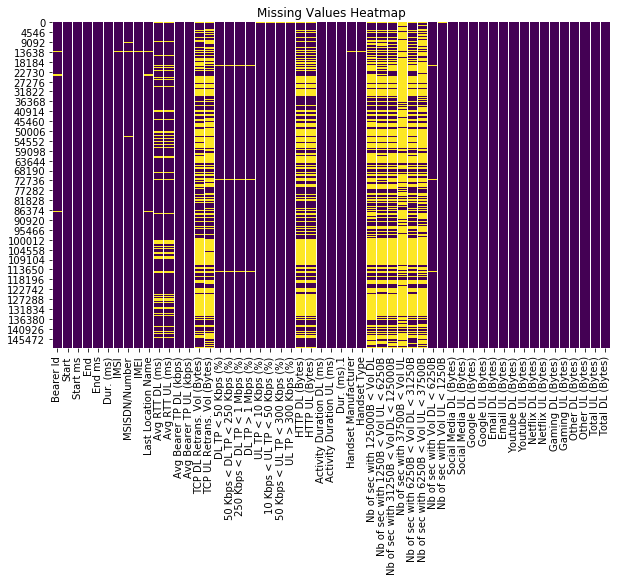

In [15]:
# function to visualize the missing value using heatmap
missing_value_heatmap(df)

In [16]:
mean_row = get_mean(df)

# Output the mean values
print("Mean values of numerical columns:")
print(mean_row)

Mean values of numerical columns:
Bearer Id                                   1.013887e+19
Start ms                                    4.991882e+02
End ms                                      4.988009e+02
Dur. (ms)                                   1.046086e+05
IMSI                                        2.082016e+14
MSISDN/Number                               4.188282e+10
IMEI                                        4.847455e+13
Avg RTT DL (ms)                             1.097957e+02
Avg RTT UL (ms)                             1.766288e+01
Avg Bearer TP DL (kbps)                     1.330005e+04
Avg Bearer TP UL (kbps)                     1.770429e+03
TCP DL Retrans. Vol (Bytes)                 2.080991e+07
TCP UL Retrans. Vol (Bytes)                 7.596587e+05
DL TP < 50 Kbps (%)                         9.284475e+01
50 Kbps < DL TP < 250 Kbps (%)              3.069355e+00
250 Kbps < DL TP < 1 Mbps (%)               1.717341e+00
DL TP > 1 Mbps (%)                          1.609654e+

In [17]:
# Fill null values with mean values
df_filled = df.fillna(mean_row)

# Output the DataFrame after filling null values
print("DataFrame after filling null values with mean:")
print(df_filled.head())

DataFrame after filling null values with mean:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name        ...         Youtube DL (Bytes)  \
0  9.16456699548519E+015        ...                 15854611.0   
1                L77566A        ...    

In [18]:
# Helper function return numerical columns from the dataframe
numeric_columns = get_numeric_columns(df)

In [19]:
# check the columns corresponds with their mean value
numeric_columns[0], mean_row[0], mean_row[numeric_columns[0]]

('Bearer Id', 1.0138874654256534e+19, 1.0138874654256534e+19)

In [20]:
# Making a copy of filled dataframe
df_no_outlier = df_filled.copy()

# Loop over the numerical columns except for bearer_id to change the outliers with the mean values
for i in range(1, len(numeric_columns)):
    # Check for outlier for the numeric columns 
    column_name = numeric_columns[i]
    outliers = detect_outliers_zscore(df_no_outlier[column_name])

    # Replace outliers with the mean value
    mean_value = mean_row[column_name]
    df_no_outlier.loc[outliers, column_name] = mean_value

# Print the DataFrame after replacing outliers with the mean value
print("DataFrame after replacing outliers with the mean value:")
print(df_no_outlier.head())

DataFrame after replacing outliers with the mean value:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

       Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  104608.560347  2.082014e+14   3.366496e+10  3.552121e+13   
1  104608.560347  2.082019e+14   3.368185e+10  3.579401e+13   
2  104608.560347  2.082003e+14   3.376063e+10  3.528151e+13   
3  104608.560347  2.082014e+14   3.375034e+10  3.535661e+13   
4  104608.560347  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name        ...         Youtube DL (Bytes)  \
0  9.16456699548519E+015        ...                 15854611.0   
1     

In [21]:
# Extract the 'Handset Type' column
handset_types = df['Handset Type']

# Count the occurrences of each handset type
handset_counts = handset_types.value_counts()

# Sort the counts in descending order
handset_counts_sorted = handset_counts.sort_values(ascending=False)

# Select the top 10 handsets
top_10_handsets = handset_counts_sorted.head(10)

# Print the top 10 handsets
print("Top 10 handsets used by the customers:")
print(top_10_handsets)

Top 10 handsets used by the customers:
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: Handset Type, dtype: int64


In [22]:
# Extract the 'Handset Manufacturer' column
handset_manufacturers = df['Handset Manufacturer']

# Count the occurrences of each handset manufacturer
manufacturer_counts = handset_manufacturers.value_counts()

# Sort the counts in descending order
manufacturer_counts_sorted = manufacturer_counts.sort_values(ascending=False)

# Select the top 3 handset manufacturers
top_3_manufacturers = manufacturer_counts_sorted.head(3)

# Print the top 3 handset manufacturers
print("Top 3 handset manufacturers:")
print(top_3_manufacturers)

Top 3 handset manufacturers:
Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64


In [23]:
# Filter the DataFrame to include only the rows corresponding to the top 3 handset manufacturers
top_3_manufacturer_names = manufacturer_counts_sorted.head(3).index
top_3_manufacturer_df = df[df['Handset Manufacturer'].isin(top_3_manufacturer_names)]

# Group the filtered DataFrame by 'Handset Manufacturer' and 'Handset Type'
grouped = top_3_manufacturer_df.groupby(['Handset Manufacturer', 'Handset Type'])

# Count the occurrences of each handset type within each manufacturer group
handset_counts_per_manufacturer = grouped.size()

# Sort the counts within each group in descending order
handset_counts_sorted_per_manufacturer = handset_counts_per_manufacturer.groupby(level=0, group_keys=False).nlargest(5)

# Select the top 5 handsets for each manufacturer
top_5_handsets_per_manufacturer = handset_counts_sorted_per_manufacturer.reset_index(level=0, drop=True)

# Print the top 5 handsets per top 3 handset manufacturers
print("Top 5 handsets per top 3 handset manufacturers:")
print(top_5_handsets_per_manufacturer)

Top 5 handsets per top 3 handset manufacturers:
Handset Type
Apple iPhone 6S (A1688)            9419
Apple iPhone 6 (A1586)             9023
Apple iPhone 7 (A1778)             6326
Apple iPhone Se (A1723)            5187
Apple iPhone 8 (A1905)             4993
Huawei B528S-23A                  19752
Huawei E5180                       2079
Huawei P20 Lite Huawei Nova 3E     2021
Huawei P20                         1480
Huawei Y6 2018                      997
Samsung Galaxy S8 (Sm-G950F)       4520
Samsung Galaxy A5 Sm-A520F         3724
Samsung Galaxy J5 (Sm-J530)        3696
Samsung Galaxy J3 (Sm-J330)        3484
Samsung Galaxy S7 (Sm-G930X)       3199
dtype: int64


In [24]:
# To aggregate the desired information per user for each application

# Filter the DataFrame
relevant_columns = ['Dur. (ms)','MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)', 
                    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                    'Google DL (Bytes)', 'Google UL (Bytes)',
                    'Email DL (Bytes)', 'Email UL (Bytes)',
                    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                    'Other DL (Bytes)', 'Other UL (Bytes)']
filtered_df = df[relevant_columns]

# Group the filtered DataFrame by 'MSISDN/Number'
grouped_df = filtered_df.groupby('MSISDN/Number')

# Calculate metrics for each user
agg_df = grouped_df.agg({
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum',
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum',
})

# Calculate number of xDR sessions and session duration
agg_df['Number of xDR sessions'] = grouped_df.size()
agg_df['Session duration'] = grouped_df['Dur. (ms)'].sum() / 1000  # Convert milliseconds to seconds

# Combine the calculated metrics
overview_df = agg_df.reset_index()

# Print the overview of users' behavior
print("Overview of users' behavior:")
print(overview_df.head())

Overview of users' behavior:
   MSISDN/Number  Total DL (Bytes)  Total UL (Bytes)  Social Media DL (Bytes)  \
0   3.360100e+10      8.426375e+08        36053108.0                2206504.0   
1   3.360100e+10      1.207552e+08        36104459.0                2598548.0   
2   3.360100e+10      5.566597e+08        39306820.0                3148004.0   
3   3.360101e+10      4.019932e+08        20327526.0                 251469.0   
4   3.360101e+10      1.363130e+09        94280527.0                2861230.0   

   Social Media UL (Bytes)  Google DL (Bytes)  Google UL (Bytes)  \
0                  25631.0          3337123.0          1051882.0   
1                  62017.0          4197697.0          1137166.0   
2                  47619.0          3343483.0            99643.0   
3                  28825.0          5937765.0          3740728.0   
4                  51312.0         13728668.0          4770948.0   

   Email DL (Bytes)  Email UL (Bytes)  Youtube DL (Bytes)  Youtube UL (Byte

In [25]:
# Extract the 'Number of xDR sessions' column from the overview DataFrame
xdr_sessions = overview_df['Number of xDR sessions']

# Print the number of xDR sessions for each user
print("xDR sessions statistical description per user:")
print(xdr_sessions.describe())

xDR sessions statistical description per user:
count    106856.000000
mean          1.393792
std           0.806022
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          18.000000
Name: Number of xDR sessions, dtype: float64


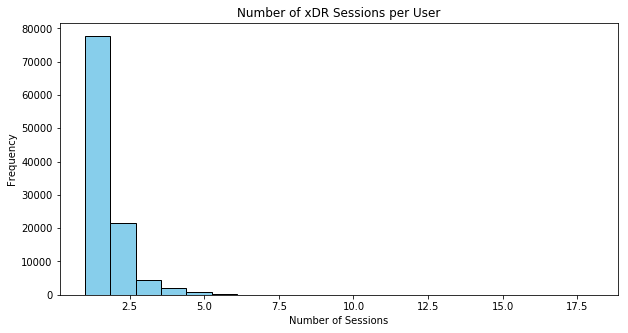

In [26]:
# Histogram of Number of xDR Sessions per User
plot_xdr_sessions_histogram(xdr_sessions)

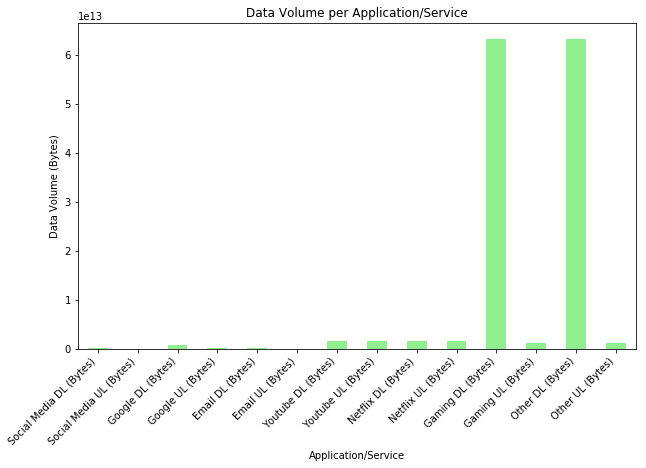

In [27]:
# Analyze data volume (UL + DL) per application/service
data_volume_per_application = df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)', 
                                   'Google DL (Bytes)', 'Google UL (Bytes)', 
                                   'Email DL (Bytes)', 'Email UL (Bytes)', 
                                   'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 
                                   'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
                                   'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 
                                   'Other DL (Bytes)', 'Other UL (Bytes)']].sum()
plt.figure(figsize=(10, 6))
data_volume_per_application.plot(kind='bar', color='lightgreen')
plt.title('Data Volume per Application/Service')
plt.xlabel('Application/Service')
plt.ylabel('Data Volume (Bytes)')
plt.xticks(rotation=45, ha='right')
plt.show()

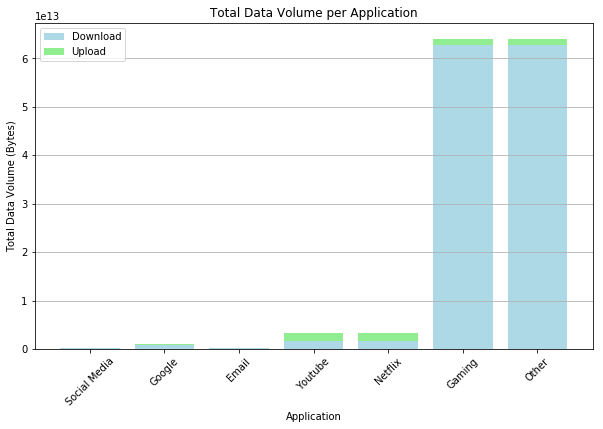

In [28]:
# Corrected Bar Plot of Total Data Volume per Application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Calculate total data volume separately for each application
total_data_volumes_dl = [overview_df[f'{col} DL (Bytes)'].sum() for col in applications]
total_data_volumes_ul = [overview_df[f'{col} UL (Bytes)'].sum() for col in applications]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(applications, total_data_volumes_dl, color='lightblue', label='Download')
plt.bar(applications, total_data_volumes_ul, bottom=total_data_volumes_dl, color='lightgreen', label='Upload')
plt.title('Total Data Volume per Application')
plt.xlabel('Application')
plt.ylabel('Total Data Volume (Bytes)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.show()


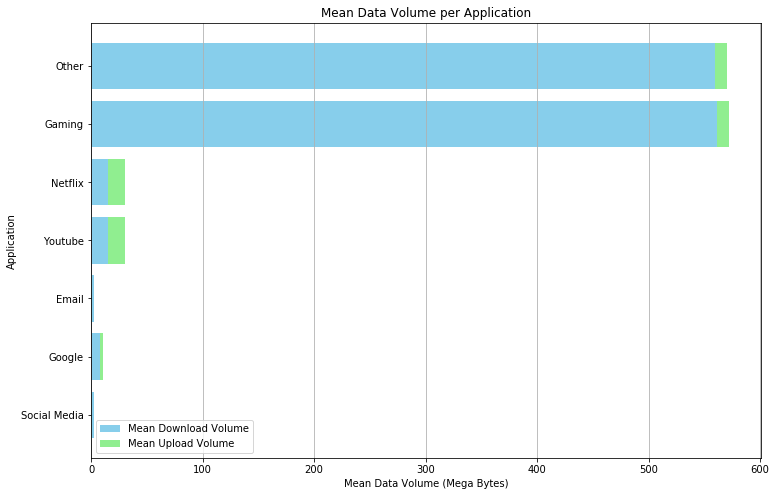

In [29]:
# Bar Charts
mean_data_volumes_dl = [overview_df[f'{col} DL (Bytes)'].mean() for col in applications]
mean_data_volumes_ul = [overview_df[f'{col} UL (Bytes)'].mean() for col in applications]

# Dividing to change the Bytes into Mega Bytes
mean_data_volumes_ul = np.array(mean_data_volumes_ul) / 1048576
mean_data_volumes_dl = np.array(mean_data_volumes_dl) / 1048576

plt.figure(figsize=(12, 8))
plt.barh(applications, mean_data_volumes_dl, color='skyblue', label='Mean Download Volume')
plt.barh(applications, mean_data_volumes_ul, left=mean_data_volumes_dl, color='lightgreen', label='Mean Upload Volume')
plt.title('Mean Data Volume per Application')
plt.xlabel('Mean Data Volume (Mega Bytes)')
plt.ylabel('Application')
plt.legend()
plt.grid(axis='x')
plt.show()

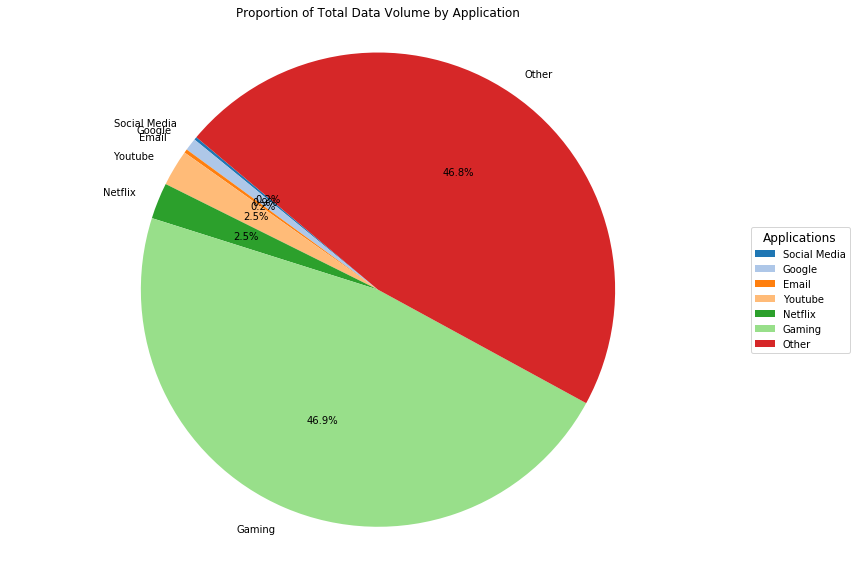

In [30]:
# Calculate total data volumes
total_data_volumes = [dl + ul for dl, ul in zip(total_data_volumes_dl, total_data_volumes_ul)]

# Pie Chart of Total Data Volume per Application
plt.figure(figsize=(12, 8))
plt.pie(total_data_volumes, labels=applications, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Proportion of Total Data Volume by Application')

# Add legend on the side with color coding and increased spacing
plt.legend(applications, loc='center left', bbox_to_anchor=(1, 0.5), title='Applications', title_fontsize='large')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust layout to prevent cramping
plt.show()

In [31]:
# Calculate total data usage for each manufacturer
df['Total Data Usage'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']

# Group by manufacturer and sum the total data usage
manufacturer_data_usage = df.groupby('Handset Manufacturer')['Total Data Usage'].sum()

# Sort the manufacturers based on their total data usage in descending order
sorted_manufacturers = manufacturer_data_usage.sort_values(ascending=False)

# Select the top 3 manufacturers
top_3_manufacturers = sorted_manufacturers.head(3)

# Display the top 3 manufacturers and their total data usage
print("Top 3 Manufacturers Based on Total Data Usage (Giga Byte):")
print(top_3_manufacturers / 1073741824)


Top 3 Manufacturers Based on Total Data Usage (Giga Byte):
Handset Manufacturer
Apple      27476.387022
Samsung    18846.951941
Huawei     15919.966836
Name: Total Data Usage, dtype: float64


In [32]:
# Group by manufacturer and sum the total data usage
handset_data_usage = df.groupby('Handset Type')['Total Data Usage'].sum()

# Sort the manufacturers based on their total data usage in descending order
sorted_handsets = handset_data_usage.sort_values(ascending=False)

# Dropping undefined handset types
sorted_handsets = sorted_handsets.drop('undefined')

# Select the top 3 manufacturers
top_5_handsets = sorted_handsets.head(5)

# Display the top 3 manufacturers and their total data usage
print("\n\nTop 5 Handsets Based on Total Data Usage (Giga Byte):")
print(top_5_handsets  / 1073741824)



Top 5 Handsets Based on Total Data Usage (Giga Byte):
Handset Type
Huawei B528S-23A           9121.036882
Apple iPhone 6S (A1688)    4360.774115
Apple iPhone 6 (A1586)     4173.862633
Apple iPhone 7 (A1778)     2923.932087
Apple iPhone Se (A1723)    2387.737570
Name: Total Data Usage, dtype: float64


In [33]:
# Calculate session duration in seconds
df['Session Duration (seconds)'] = df['Dur. (ms)'] / 1000

# Group by handset type and calculate the total session duration for each handset
handset_session_duration = df.groupby('Handset Type')['Session Duration (seconds)'].sum()

# Sort the handsets based on their session duration in descending order
sorted_handsets = handset_session_duration.sort_values(ascending=False)

# Dropping undefined handset name
sorted_handsets = sorted_handsets.drop('undefined')

# Select the top 10 handsets with the longest session duration
top_10_handsets = sorted_handsets.head(10)

# Display the top 10 handsets based on session duration
print("Top 10 Handsets Based on Session Duration:")
print(top_10_handsets)

Top 10 Handsets Based on Session Duration:
Handset Type
Huawei B528S-23A                1837464.812
Apple iPhone 6S (A1688)          995784.891
Apple iPhone 6 (A1586)           844430.374
Samsung Galaxy J5 (Sm-J530)      624112.870
Apple iPhone 7 (A1778)           576169.308
Apple iPhone Se (A1723)          540346.006
Samsung Galaxy S8 (Sm-G950F)     513333.661
Apple iPhone Xr (A2105)          504315.644
Apple iPhone 8 (A1905)           497229.596
Samsung Galaxy A5 Sm-A520F       480445.715
Name: Session Duration (seconds), dtype: float64


In [34]:
# Descriptive Statistics
statistics_df = overview_df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                              'Google DL (Bytes)', 'Google UL (Bytes)',
                              'Email DL (Bytes)', 'Email UL (Bytes)',
                              'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                              'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                              'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                              'Other DL (Bytes)', 'Other UL (Bytes)']].describe()

print("Descriptive Statistics for Data Volume (Bytes) per Application:")
print(statistics_df)

Descriptive Statistics for Data Volume (Bytes) per Application:
       Social Media DL (Bytes)  Social Media UL (Bytes)  Google DL (Bytes)  \
count             1.068560e+05            106856.000000       1.068560e+05   
mean              2.502081e+06             45886.012802       8.016496e+06   
std               1.887588e+06             34717.044775       6.065160e+06   
min               1.200000e+01                 0.000000       2.070000e+02   
25%               1.175902e+06             21600.750000       3.802894e+06   
50%               2.265000e+06             41559.500000       7.256742e+06   
75%               3.267238e+06             59919.250000       1.043106e+07   
max               4.274384e+07            630942.000000       1.161065e+08   

       Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  \
count       1.068560e+05      1.068560e+05      1.068560e+05   
mean        2.865938e+06      2.497352e+06      6.514435e+05   
std         2.172787e+06      1.897063e+0

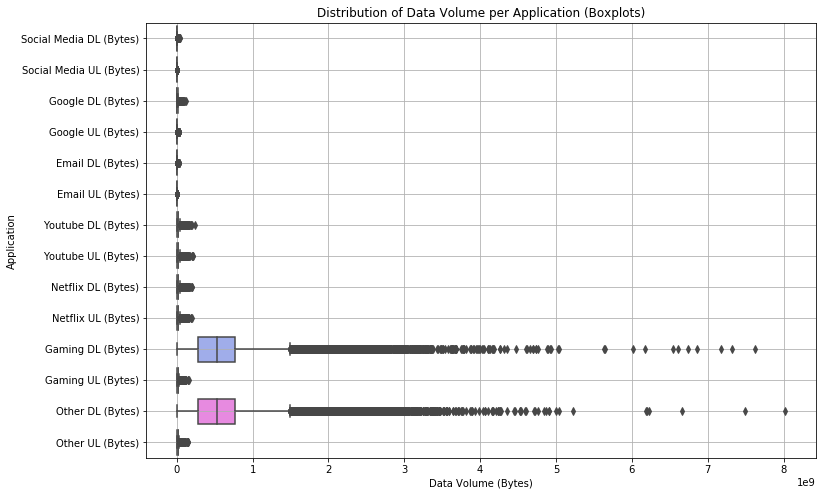

In [35]:
# Boxplots for visualizing the distribution of the application data usage
plt.figure(figsize=(12, 8))
sns.boxplot(data=overview_df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                              'Google DL (Bytes)', 'Google UL (Bytes)',
                              'Email DL (Bytes)', 'Email UL (Bytes)',
                              'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                              'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                              'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                              'Other DL (Bytes)', 'Other UL (Bytes)']], orient='h')
plt.title('Distribution of Data Volume per Application (Boxplots)')
plt.xlabel('Data Volume (Bytes)')
plt.ylabel('Application')
plt.grid(True)
plt.show()

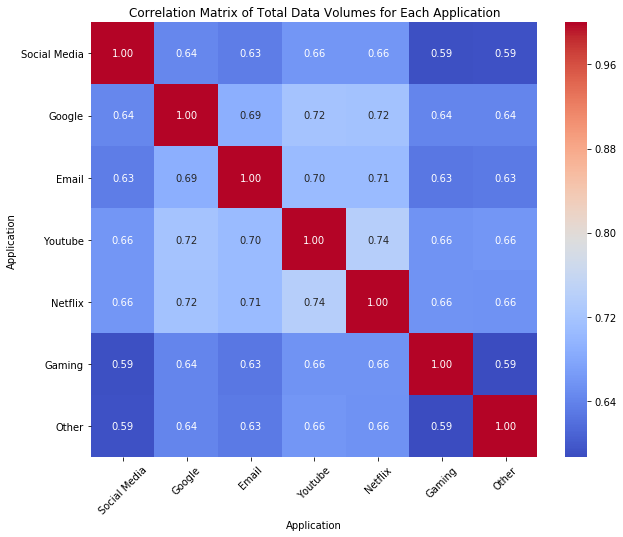

In [36]:
# Calculate total volumes (DL + UL) for each application
social_media_total = overview_df['Social Media DL (Bytes)'] + overview_df['Social Media UL (Bytes)']
google_total = overview_df['Google DL (Bytes)'] + overview_df['Google UL (Bytes)']
email_total = overview_df['Email DL (Bytes)'] + overview_df['Email UL (Bytes)']
youtube_total = overview_df['Youtube DL (Bytes)'] + overview_df['Youtube UL (Bytes)']
netflix_total = overview_df['Netflix DL (Bytes)'] + overview_df['Netflix UL (Bytes)']
gaming_total = overview_df['Gaming DL (Bytes)'] + overview_df['Gaming UL (Bytes)']
other_total = overview_df['Other DL (Bytes)'] + overview_df['Other UL (Bytes)']

# Create a DataFrame with total volumes for each application
total_volumes_df = pd.DataFrame({
    'Social Media': social_media_total,
    'Google': google_total,
    'Email': email_total,
    'Youtube': youtube_total,
    'Netflix': netflix_total,
    'Gaming': gaming_total,
    'Other': other_total
})

# Calculate the correlation matrix
correlation_matrix = total_volumes_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Total Data Volumes for Each Application')
plt.xlabel('Application')
plt.ylabel('Application')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [37]:
# Calculate total download (DL) and upload (UL) data for all applications combined
total_dl = overview_df[[col for col in overview_df.columns if 'DL' in col]].sum(axis=1)
total_ul = overview_df[[col for col in overview_df.columns if 'UL' in col]].sum(axis=1)

# Calculate total data volume (DL + UL) for all applications combined
total_data_volume = total_dl + total_ul

# Print total data volume
print("Total Data Volume (Bytes) for all Applications Combined:")
total_data_sum = total_data_volume.sum()
print()
print(total_data_sum, 'Byte, or', total_data_sum / 1099511627776, 'Tera Byte')

Total Data Volume (Bytes) for all Applications Combined:

210390467466167.0 Byte, or 191.34901546400852 Tera Byte


In [38]:
# Calculate the total duration for all sessions for each user
agg_df['Total Session Duration'] = grouped_df['Dur. (ms)'].sum() / 1000  # Convert milliseconds to seconds

# Segment users into deciles based on the total duration
decile_classes = pd.qcut(agg_df['Total Session Duration'], q=10, labels=False)

# Compute the total data (DL+UL) for each user
agg_df['Total Data (DL+UL)'] = agg_df['Total DL (Bytes)'] + agg_df['Total UL (Bytes)']

# Aggregate the total data (DL+UL) per decile class
data_per_decile = agg_df.groupby(decile_classes)['Total Data (DL+UL)'].sum()

# Sort the deciles based on total session duration
sorted_deciles = data_per_decile.sort_values(ascending=False)

# Select the top 5 deciles with the highest total session duration
top_5_deciles = sorted_deciles.head(5)

# Print the top 5 deciles with the highest total session duration
print("Top 5 Deciles with Highest Total Session Duration:")
print(top_5_deciles)

Top 5 Deciles with Highest Total Session Duration:
Total Session Duration
9    1.486393e+13
8    9.305495e+12
7    7.822234e+12
2    6.536402e+12
5    6.426251e+12
Name: Total Data (DL+UL), dtype: float64


In [39]:
# Calculate the total duration for all sessions for each user
agg_df['Total Session Duration'] = grouped_df['Dur. (ms)'].sum() / 1000  # Convert milliseconds to seconds

# Segment users into deciles based on the total duration
agg_df['Decile Class'] = pd.qcut(agg_df['Total Session Duration'], q=10, labels=False)

# Compute the total data (DL+UL) per decile class
agg_df['Total Data (DL+UL)'] = agg_df['Total DL (Bytes)'] + agg_df['Total UL (Bytes)']

# Aggregate the total data (DL+UL) per decile class
total_data_per_decile = agg_df.groupby('Decile Class')['Total Data (DL+UL)'].sum()

# Print the total data (DL+UL) per decile class
print("Total Data (DL+UL in Gega Byte) per Decile Class:")
print(total_data_per_decile / 1073741824)

# Sort the deciles based on total session duration
sorted_deciles = total_data_per_decile.sort_index(ascending=False)

# Select the top 5 deciles with the highest total session duration
top_5_deciles = sorted_deciles.head(5)

# Print the top 5 deciles with the highest total session duration
print("\nTop 5 Deciles based on Total Session Duration in Gega Byte:")
print(top_5_deciles / 1073741824)

# Compute the total data (DL+UL) in each decile
total_data_in_top_5_deciles = agg_df[agg_df['Decile Class'].isin(top_5_deciles.index)]['Total Data (DL+UL)'].sum()

# Print the total data (DL+UL) in each decile
print("\nTotal Data (DL+UL in Tera Byte) by the top 5 Deciles:")
print(total_data_in_top_5_deciles / (1073741824 * 1024))

Total Data (DL+UL in Gega Byte) per Decile Class:
Decile Class
0     5065.721127
1     5689.831830
2     6087.498457
3     5619.824693
4     4790.473507
5     5984.912810
6     5729.941504
7     7285.023306
8     8666.417429
9    13843.110832
Name: Total Data (DL+UL), dtype: float64

Top 5 Deciles based on Total Session Duration in Gega Byte:
Decile Class
9    13843.110832
8     8666.417429
7     7285.023306
6     5729.941504
5     5984.912810
Name: Total Data (DL+UL), dtype: float64

Total Data (DL+UL in Tera Byte) by the top 5 Deciles:
40.536529182057166


In [40]:
# Calculate the average session duration for each decile class
avg_session_duration_per_decile = agg_df.groupby('Decile Class')['Total Session Duration'].mean()

# Sort the average session duration in descending order
sorted_avg_session_duration = avg_session_duration_per_decile.sort_values(ascending=False)

# Select the top 5 deciles with the highest average session duration
top_5_highest_duration_deciles = sorted_avg_session_duration.head(5)

# Print the top 5 highest duration decile classes and their total duration
print("Top 5 Highest Duration Decile Classes and Their Total Duration:")
for decile_class, avg_duration in top_5_highest_duration_deciles.items():
    total_duration = agg_df[agg_df['Decile Class'] == decile_class]['Total Session Duration'].sum()
    print(f"Decile Class: {decile_class}, Total Duration: {total_duration} seconds")


Top 5 Highest Duration Decile Classes and Their Total Duration:
Decile Class: 9, Total Duration: 5106533.529 seconds
Decile Class: 8, Total Duration: 2486470.418 seconds
Decile Class: 7, Total Duration: 1869399.264 seconds
Decile Class: 6, Total Duration: 1579210.392 seconds
Decile Class: 5, Total Duration: 1254869.255 seconds


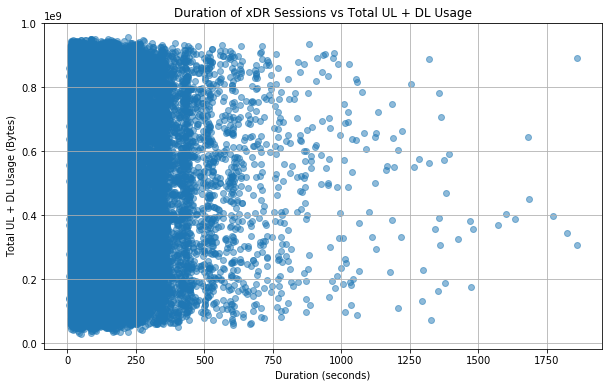

In [41]:
# Calculate Total UL + DL Usage
df['Total UL + DL'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']

# Plot the Data
plt.figure(figsize=(10, 6))
plt.scatter(df['Dur. (ms)'] / 1000, df['Total UL + DL'], alpha=0.5)
plt.title('Duration of xDR Sessions vs Total UL + DL Usage')
plt.xlabel('Duration (seconds)')
plt.ylabel('Total UL + DL Usage (Bytes)')
plt.grid(True)
plt.show()


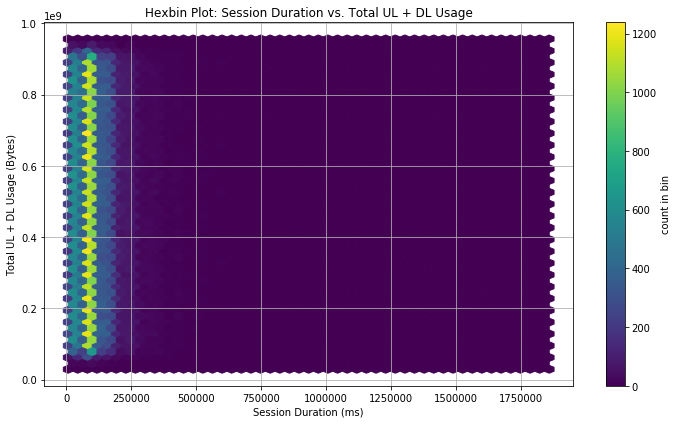

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns 'Dur. (ms)', 'Total UL (Bytes)', and 'Total DL (Bytes)'

# Calculate Total UL + DL Usage
df['Total UL + DL'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']

# Plot the hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(df['Dur. (ms)'], df['Total UL + DL'], gridsize=50, cmap='viridis')
plt.colorbar(label='count in bin')
plt.title('Hexbin Plot: Session Duration vs. Total UL + DL Usage')
plt.xlabel('Session Duration (ms)')
plt.ylabel('Total UL + DL Usage (Bytes)')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

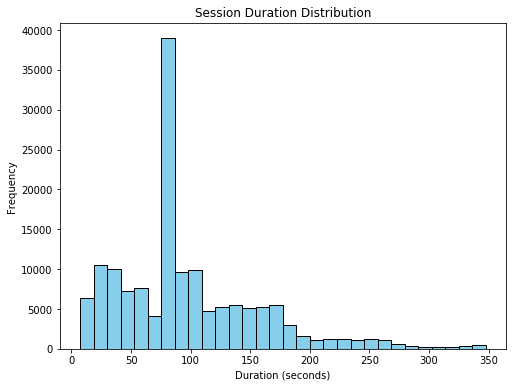

In [43]:
# Analyze session duration distribution
session_duration_distribution = df_no_outlier['Dur. (ms)'] / 1000  # Convert milliseconds to seconds
plt.figure(figsize=(8, 6))
plt.hist(session_duration_distribution, bins=30, color='skyblue', edgecolor='black')
plt.title('Session Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

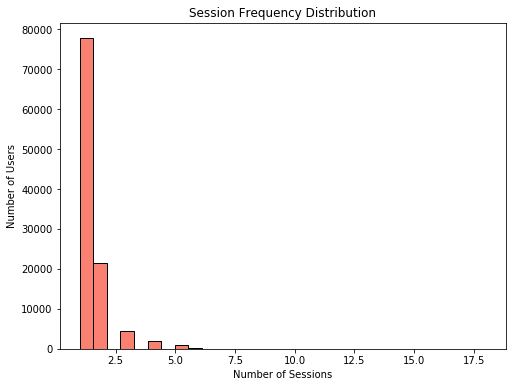

In [44]:
# Analyze session frequency per user
session_frequency = df['MSISDN/Number'].value_counts()
plt.figure(figsize=(8, 6))
plt.hist(session_frequency, bins=30, color='salmon', edgecolor='black')
plt.title('Session Frequency Distribution')
plt.xlabel('Number of Sessions')
plt.ylabel('Number of Users')
plt.show()

In [45]:
# Analyze network performance metrics
network_performance_metrics = df[['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 
                                   'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 
                                   'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']].describe()
print(network_performance_metrics)


       Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
count    122172.000000    122189.000000            150000.000000   
mean        109.795706        17.662883             13300.045927   
std         619.782739        84.793524             23971.878541   
min           0.000000         0.000000                 0.000000   
25%          32.000000         2.000000                43.000000   
50%          45.000000         5.000000                63.000000   
75%          70.000000        15.000000             19710.750000   
max       96923.000000      7120.000000            378160.000000   

       Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  \
count            150000.000000                 6.185500e+04   
mean               1770.428647                 2.080991e+07   
std                4625.355500                 1.825665e+08   
min                   0.000000                 2.000000e+00   
25%                  47.000000                 3.565150e+04   
50%      

In [46]:
# Calculate session duration in seconds
df['Session Duration (seconds)'] = df['Dur. (ms)'].head() / 1000

# Calculate mean and median session duration
session_duration_mean = df['Session Duration (seconds)'].mean()
session_duration_median = df['Session Duration (seconds)'].median()

# Print mean and median session duration
print("Mean Session Duration:", session_duration_mean, "seconds")
print("Median Session Duration:", session_duration_median, "seconds")

Mean Session Duration: 1392.2072 seconds
Median Session Duration: 1361.762 seconds


In [47]:
# Identifying the datetime columns in the dataframe
datetime_columns = df.select_dtypes(include=['datetime64']).columns
datetime_columns

Index([], dtype='object')

In [48]:
df[datetime_columns].head()

""
0
1
2
3
4


In [49]:
# Remove non-numeric columns
numeric_df = df.select_dtypes(include=['number'])

numeric_df.head()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Total Data Usage,Session Duration (seconds),Total UL + DL
0,1.311448e+19,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.0,5.0,23.0,...,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0,345629377.0,1823.652,345629377.0
1,1.311448e+19,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.0,5.0,16.0,...,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0,707185356.0,1365.104,707185356.0
2,1.311448e+19,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,NaN,NaN,6.0,...,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0,307690973.0,1361.762,307690973.0
3,1.311448e+19,486.0,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,NaN,NaN,44.0,...,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0,889352748.0,1321.509,889352748.0
4,1.311448e+19,565.0,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,NaN,NaN,6.0,...,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0,607681403.0,1089.009,607681403.0


In [50]:
# changing the datatime columns in to the numbers to make the pca work 
for column in datetime_columns:
    numeric_df[column] = pd.to_numeric(df[column])

In [51]:
# Handle missing values replacing with 0
numeric_df = numeric_df.fillna(0)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
    
# Apply PCA
pca = PCA()
pca.fit(scaled_data)
    
# Explained Variance Ratio: Check the variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative Variance Explained: Determine the cumulative variance explained by adding up the individual explained variances
cumulative_variance_explained = explained_variance_ratio.cumsum()

Interpret the results

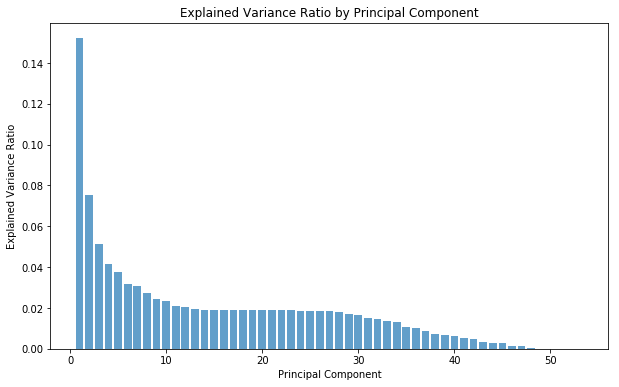

In [52]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

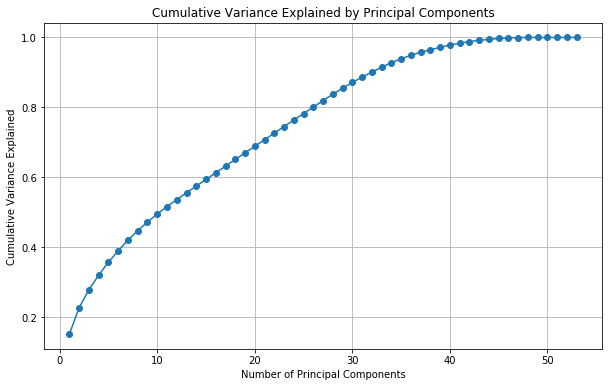

In [53]:
# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [54]:
# Determine the optimal number of components: Select the number of principal components that explain a significant portion of the variance (e.g., 80%)
num_components = len(cumulative_variance_explained[cumulative_variance_explained <= 0.8])
print("Number of Components to Explain 80% Variance:", num_components)

Number of Components to Explain 80% Variance: 25


In [55]:
# Analyze the loadings of each feature on the principal components to understand the underlying structure of the data
principal_components = pca.components_
print("Principal Components shape:", principal_components.shape)

Principal Components shape: (53, 53)


In [56]:
# Printing the top 10 user engagement using three metrics, session frequency, duration and total data trafic
aggregate_metric_analyze(df.copy())

Top 10 Users by Session Frequency:
MSISDN/Number
3.362632e+10    18
3.361489e+10    17
3.362578e+10    16
3.365973e+10    15
3.376054e+10    15
3.367588e+10    15
3.366716e+10    13
3.362708e+10    12
3.378632e+10    12
3.360313e+10    12
Name: Start, dtype: int64

Top 10 Users by Total Session Duration:
                Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  Total Traffic
MSISDN/Number                                                               
3.362578e+10   18553754.0      7.770043e+09       729577380.0   8.499621e+09
3.361489e+10    9966898.0      8.156743e+09       689483001.0   8.846226e+09
3.376054e+10    9279434.0      7.811295e+09       703478581.0   8.514774e+09
3.362632e+10    8791927.0      7.301517e+09       669650721.0   7.971167e+09
3.366716e+10    8744914.0      5.052068e+09       566326364.0   5.618394e+09
3.366284e+10    6614270.0      3.593674e+09       406424372.0   4.000098e+09
3.366469e+10    6288730.0      5.279827e+09       402180804.0   5.682007e+09
3

Clustering to classify customers in three groups of engagement

In [100]:
# normalize and cluster user data's on the given engagement metrics
user_data_with_clusters = normalize_and_cluster(df.copy())

print(user_data_with_clusters.head())

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


   MSISDN/Number  Dur. (ms)  Session Frequency  Total Traffic  Cluster
0   3.360100e+10   116720.0                  1   8.786906e+08        0
1   3.360100e+10   181230.0                  1   1.568596e+08        0
2   3.360100e+10   134969.0                  1   5.959665e+08        0
3   3.360101e+10    49878.0                  1   4.223207e+08        0
4   3.360101e+10    37104.0                  2   1.457411e+09        1


In [58]:
user_data_with_clusters['Cluster'].value_counts()

0    81164
1    21631
2     4061
Name: Cluster, dtype: int64

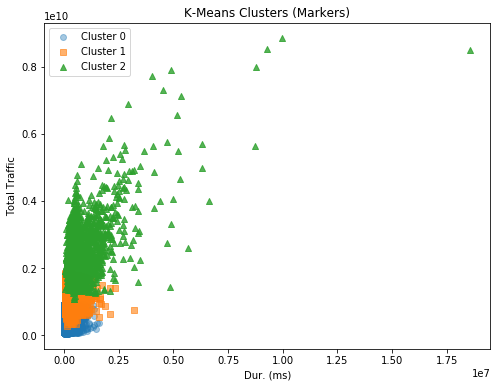

In [59]:
# Preprocess data and get results with cluster labels
result = user_data_with_clusters

# Features for visualization are 'Dur. (ms)', 'Total Traffic'
features_to_visualize = ['Dur. (ms)', 'Total Traffic']

# Scatter plot for the clusters
plot_scatter_cluster(result, features_to_visualize)


c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


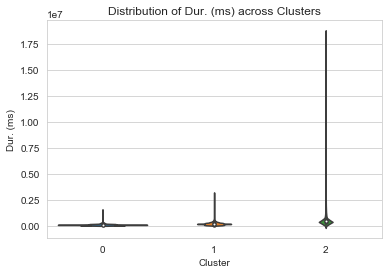

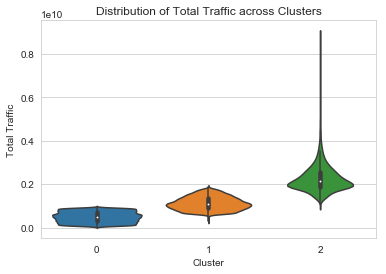

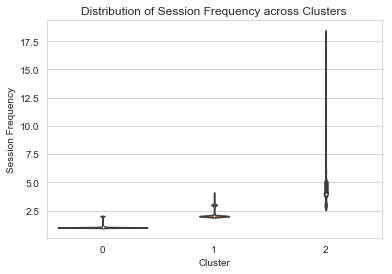

In [60]:
# Cluster distribution using violin plot
visualize_distributions(user_data_with_clusters)

In [61]:
# Group data by cluster label
cluster_data = result.groupby('Cluster')

# Calculate statistics for non-normalized features (assuming 'Dur. (ms)', 'Total Traffic', 'Session Frequency')
stats = cluster_data[['Dur. (ms)', 'Total Traffic', 'Session Frequency']].agg(['min', 'max', 'mean', 'sum'])


In [62]:
# Analyze clusters and get descriptive statistics
cluster_stats = analyze_clusters(result.copy())

# Print the results
cluster_stats

Cluster Dur. (ms)                                          Total Traffic  \
                min         max           mean           sum           min   
0       0    7142.0   1573420.0  106994.977219  8.684140e+09  3.324901e+07   
1       1   18235.0   3174824.0  213623.106606  4.620881e+09  2.842182e+08   
2       2   46896.0  18553754.0  569765.059345  2.313816e+09  1.085994e+09   

                                            Session Frequency                \
            max          mean           sum               min max      mean   
0  9.507607e+08  4.955147e+08  4.021796e+13                 1   2  1.042297   
1  1.873330e+09  1.125738e+09  2.435085e+13                 2   4  2.176460   
2  8.846226e+09  2.281370e+09  9.264643e+12                 3  18  4.249938   

         Total Users  
     sum              
0  84597       81164  
1  47079       21631  
2  17259        4061

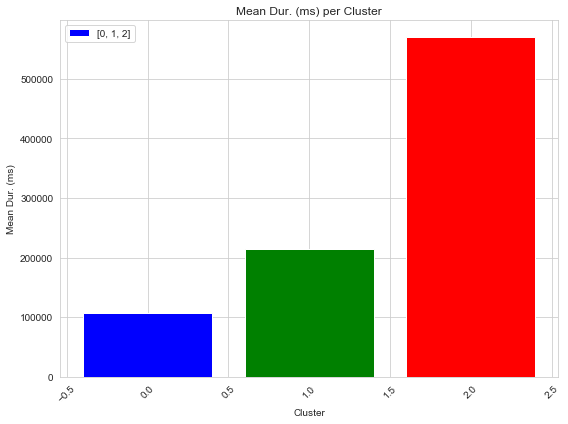

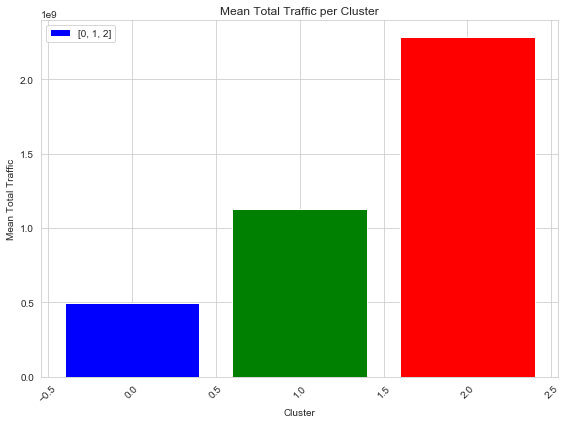

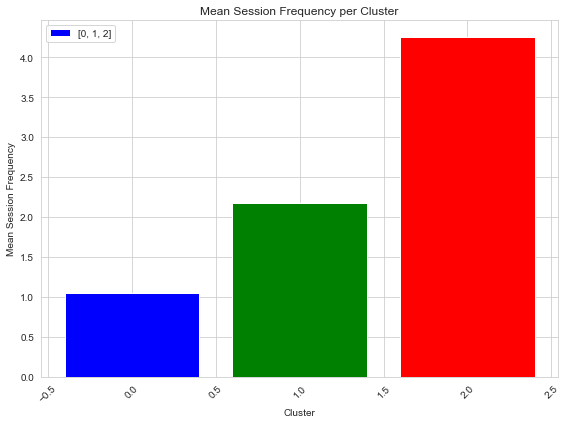

In [66]:
# Drawing a pie chart to visualize the cluster distribution in the engagement metrics
features_to_plot = ['Dur. (ms)', 'Total Traffic', 'Session Frequency']
stat_to_plot = 'mean'
for feature in features_to_plot:
  plot_bar_cluster_stats(cluster_stats.copy(), feature, stat_to_plot)

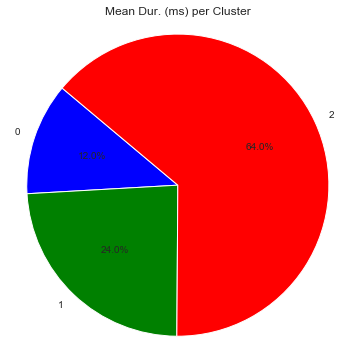

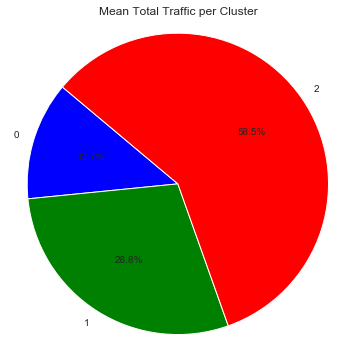

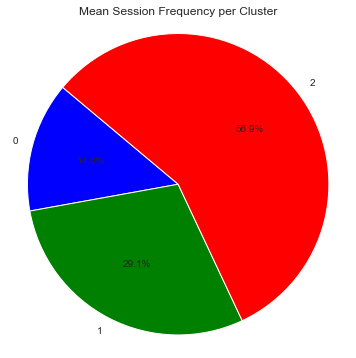

In [73]:
# Drawing a pie chart to visualize the cluster distribution in the engagement metrics
features_to_plot = ['Dur. (ms)', 'Total Traffic', 'Session Frequency']
stat_to_plot = 'mean'
for feature in features_to_plot:
  plot_pie_cluster_stats(cluster_stats.copy(), feature, stat_to_plot)

In [76]:
df_no_outlier.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [79]:
# Create new columns for the sum of UL + DL for each application
df['Social Media Total (Bytes)'] = df['Social Media DL (Bytes)'] + df['Social Media UL (Bytes)']
df['Google Total (Bytes)'] = df['Google DL (Bytes)'] + df['Google UL (Bytes)']
df['Email Total (Bytes)'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)']
df['Youtube Total (Bytes)'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
df['Netflix Total (Bytes)'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
df['Gaming Total (Bytes)'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']
df['Other Total (Bytes)'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']

# Grouping by Application and aggregating the sum of UL + DL for each application
app_usage = df.groupby('MSISDN/Number').agg({
    'Social Media Total (Bytes)': 'sum',
    'Google Total (Bytes)': 'sum',
    'Email Total (Bytes)': 'sum',
    'Youtube Total (Bytes)': 'sum',
    'Netflix Total (Bytes)': 'sum',
    'Gaming Total (Bytes)': 'sum',
    'Other Total (Bytes)': 'sum'
})

# Initialize a dictionary to store top 10 users per application
top_10_users_per_app = {}

# Iterate over each application and identify top 10 users
for app in app_usage.columns:
    top_10_users_per_app[app] = df.nlargest(10, app)

# Displaying the top 10 users for each application
for app, top_users in top_10_users_per_app.items():
    print(f"Top 10 Users for {app}:")
    print(top_users[['MSISDN/Number', app]])
    print("\n")

Top 10 Users for Social Media Total (Bytes):
        MSISDN/Number  Social Media Total (Bytes)
32228    3.366178e+10                   3650861.0
105244   3.375024e+10                   3650240.0
147105   3.365205e+10                   3648814.0
50260    3.365856e+10                   3648729.0
98116    3.361008e+10                   3648659.0
31918    3.366264e+10                   3648092.0
45513    3.376091e+10                   3648027.0
11172    3.366237e+10                   3647700.0
9965     3.364551e+10                   3647486.0
7440     3.366887e+10                   3647484.0


Top 10 Users for Google Total (Bytes):
       MSISDN/Number  Google Total (Bytes)
92924   3.363243e+10            15528782.0
48788   3.366485e+10            15517324.0
80845   3.366092e+10            15508567.0
27395   3.365976e+10            15507131.0
3333    3.366466e+10            15506449.0
53083   3.366733e+10            15506141.0
82620   3.366775e+10            15493921.0
90242   3.377121e+10

In [99]:
# Calculate the total data usage for each application
total_usage = app_usage.sum()

# Sort the total data usage in descending order and select the top 3 applications
top_3_apps = total_usage.nlargest(3)

top_3_apps

Gaming Total (Bytes)     6.408892e+13
Other Total (Bytes)      6.395425e+13
Youtube Total (Bytes)    3.372204e+12
dtype: float64

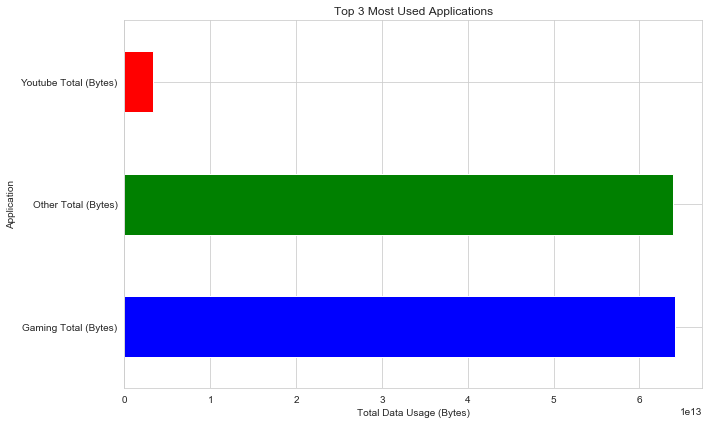

In [84]:
# Plotting the top 3 most used applications as a horizontal bar chart
plt.figure(figsize=(10, 6))
top_3_apps.plot(kind='barh', color=['blue', 'green', 'red'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Data Usage (Bytes)')
plt.ylabel('Application')
plt.tight_layout()
plt.show()

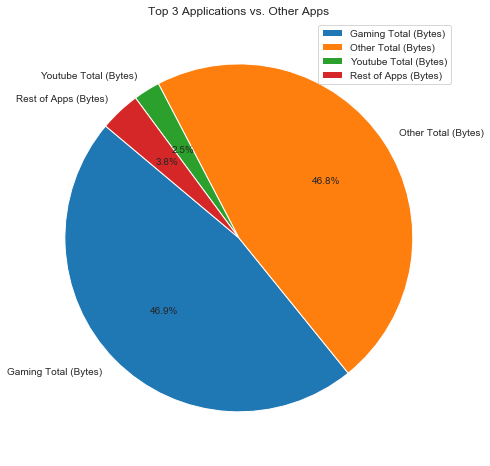

In [96]:
# Sort applications based on total data usage
sorted_apps = app_usage.sum().sort_values(ascending=False, axis=0)

# Select top 3 applications and compute total data usage for the rest
top_3 = sorted_apps.head(3)
rest_usage = sorted_apps[3:].sum()

# Create a new DataFrame with top 3 applications and the rest
top_4 = top_3.append(pd.Series(rest_usage, index=['Rest of Apps (Bytes)']))

# Plot a pie chart
plt.figure(figsize=(8, 8))
top_4.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 3 Applications vs. Other Apps')
plt.ylabel('')
plt.legend()
plt.show()

In [145]:
# Group data by user (MSISDN/Number)
grouped_data = df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',        # Total session duration (ms)
    'Total DL (Bytes)': 'sum', # Total traffic (download)
    'Total UL (Bytes)': 'sum'  # Total traffic (upload)
}).reset_index()

# Get the frequency of each entry
frequency = df.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')

# Merge the frequency into the grouped data
result = pd.merge(grouped_data, frequency, on='MSISDN/Number')

# Combine download and upload traffic into a single 'Total Traffic' metric
result['Total Traffic'] = result['Total DL (Bytes)'] + result['Total UL (Bytes)']
result.drop(columns=['Total DL (Bytes)', 'Total UL (Bytes)'], inplace=True)

In [146]:
result.head()

,MSISDN/Number,Dur. (ms),Session Frequency,Total Traffic
0,3.360100e+10,116720.0,1,8.786906e+08
1,3.360100e+10,181230.0,1,1.568596e+08
2,3.360100e+10,134969.0,1,5.959665e+08
3,3.360101e+10,49878.0,1,4.223207e+08
4,3.360101e+10,37104.0,2,1.457411e+09


In [ ]:
# Select features for normalization and clustering
features = ['Dur. (ms)', 'Total Traffic', 'Session Frequency']

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(result[features])

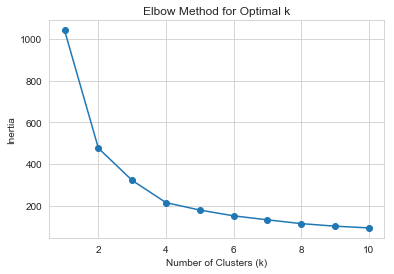

In [147]:
# Find optimal value of k using elbow method
inertias = []
k_range = range(1, 11)  # Range of k values to try
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [154]:
# Based on the elbow curve, choose the optimal value of k
optimal_k = 4  # Optimal k is chosen as change per elbow curve analysis)

# Perform k-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to user data DataFrame
result['Cluster'] = kmeans.labels_

In [155]:
result[features].head()

,Dur. (ms),Total Traffic,Session Frequency
0,0.017647,0.149634,1
1,0.027400,0.026712,1
2,0.020406,0.101488,1
3,0.007541,0.071918,1
4,0.005610,0.248186,2


In [156]:
result['Dur. (ms)'] = scaled_data[:, 0]
result['Total Traffic'] = scaled_data[:, 1]
result.head()

,MSISDN/Number,Dur. (ms),Session Frequency,Total Traffic,Cluster
0,3.360100e+10,0.017647,1,0.149634,2
1,3.360100e+10,0.027400,1,0.026712,0
2,3.360100e+10,0.020406,1,0.101488,2
3,3.360101e+10,0.007541,1,0.071918,0
4,3.360101e+10,0.005610,2,0.248186,1


In [163]:
# Get cluster counts as a Series
cluster_counts = result['Cluster'].value_counts()
cluster_counts

2    45562
0    41514
1    16356
3     3424
Name: Cluster, dtype: int64

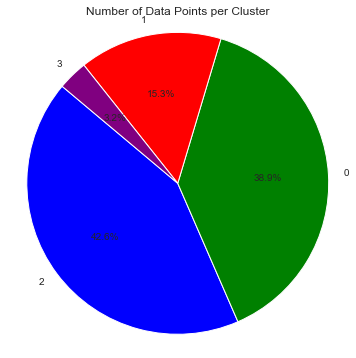

In [168]:
# Assuming result is a DataFrame containing a 'cluster' column
cluster_labels = result['Cluster'].unique()  # Get unique cluster labels
cluster_counts = result['Cluster'].value_counts()  # Count occurrences of each cluster

# Define pie chart colors (adjust colors as needed)
colors = ['blue', 'green', 'red', 'purple']  # Assuming several clusters

# Create a pie chart with cluster labels and colors
plt.figure(figsize=(6, 6))  # Adjust figure size for pie charts
plt.pie(cluster_counts, labels=cluster_labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title('Number of Data Points per Cluster')
plt.axis('equal')  # Equal aspect ratio for a circular pie chart
plt.show()

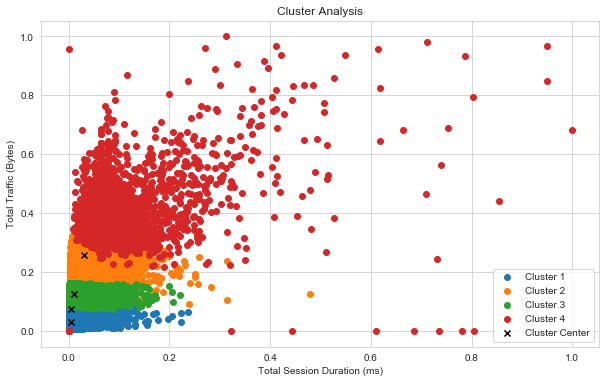

In [157]:
# Call the function to adjust outliers
result_adjusted = adjust_outliers(result, cluster_centers)

# Plot clusters with adjusted outliers
plot_clusters(result_adjusted)